In [7]:
# Started 2022-2-20
# 

# Original comment:
"""
This is an experimental high-performance EPI sequence which uses split gradients to overlap blips with the readout 
gradients combined with ramp-sampling.
"""

import math
import numpy as np
import pypulseq as pp

# Custom functions
import viz # visualization

In [8]:
# ======
# SETUP
# ======
seq = pp.Sequence()  # Create a new sequence object
fov = 160e-3  # Define FOV and resolution
Nx = 2**5
Ny = Nx
slice_thickness = 3e-3  # Slice thickness
n_slices = 1
TE = 40e-3

pe_enable = 1  # Flag to quickly disable phase encoding (1/0) as needed for the delay calibration
ro_os = 1  # Oversampling factor
readout_time = 4.2e-4  # Readout bandwidth
# Partial Fourier factor: 1: full sampling; 0: start with ky=0
part_fourier_factor = 1

t_RF_ex = 2e-3
t_RF_ref = 2e-3
spoil_factor = 1.5  # Spoiling gradient around the pi-pulse (rf180)

# Set system limits
system = pp.Opts(
        max_grad=32,
        grad_unit="mT/m",
        max_slew=130,
        slew_unit="T/m/s",
        rf_ringdown_time=30e-6,
        rf_dead_time=100e-6,
    )

# ======
# CREATE EVENTS
# ======
# Create fat-sat pulse
B0 = 2.89
sat_ppm = -3.45
sat_freq = sat_ppm * 1e-6 * B0 * system.gamma
rf_fs = pp.make_gauss_pulse(
    flip_angle=110 * np.pi / 180,
    system=system,
    duration=8e-3,
    bandwidth=abs(sat_freq),
    freq_offset=sat_freq,
)
gz_fs = pp.make_trapezoid(
    channel="z", system=system, delay=pp.calc_duration(rf_fs), area=1 / 1e-4
)

# Create 90 degree slice selection pulse and gradient
rf, gz, gz_reph = pp.make_sinc_pulse(
    flip_angle=np.pi / 2,
    system=system,
    duration=t_RF_ex,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    return_gz=True,
)

# Create 90 degree slice refocusing pulse and gradients
rf180, gz180, _ = pp.make_sinc_pulse(
    flip_angle=np.pi,
    system=system,
    duration=t_RF_ref,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=np.pi / 2,
    use="refocusing",
    return_gz=True,
)
_, gzr1_t, gzr1_a = pp.make_extended_trapezoid_area(
    channel="z",
    grad_start=0,
    grad_end=gz180.amplitude,
    area=spoil_factor * gz.area,
    system=system,
)
_, gzr2_t, gzr2_a = pp.make_extended_trapezoid_area(
    channel="z",
    grad_start=gz180.amplitude,
    grad_end=0,
    area=-gz_reph.area + spoil_factor * gz.area,
    system=system,
)
if gz180.delay > (gzr1_t[3] - gz180.rise_time):
    gz180.delay -= gzr1_t[3] - gz180.rise_time
else:
    rf180.delay += (gzr1_t[3] - gz180.rise_time) - gz180.delay
gz180n = pp.make_extended_trapezoid(
    channel="z",
    system=system,
    times=np.array([*gzr1_t, *gzr1_t[3] + gz180.flat_time + gzr2_t]) + gz180.delay,
    amplitudes=np.array([*gzr1_a, *gzr2_a]),
)

# Define the output trigger to play out with every slice excitation
trig = pp.make_digital_output_pulse(channel="osc0", duration=100e-6)

# Define other gradients and ADC events
delta_k = 1 / fov
k_width = Nx * delta_k

# Phase blip in shortest possible time
# Round up the duration to 2x gradient raster time
blip_duration = (
    np.ceil(2 * np.sqrt(delta_k / system.max_slew) / 10e-6 / 2) * 10e-6 * 2
)
# Use negative blips to save one k-space line on our way to center of k-space
gy = pp.make_trapezoid(
    channel="y", system=system, area=delta_k, duration=blip_duration
)

# Readout gradient is a truncated trapezoid with dead times at the beginning and at the end each equal to a half of
# blip duration. The area between the blips should be defined by k_width. We do a two-step calculation: we first
# increase the area assuming maximum slew rate and then scale down the amplitude to fix the area
extra_area = blip_duration / 2 * blip_duration / 2 * system.max_slew
gx = pp.make_trapezoid(
    channel="x",
    system=system,
    area=k_width + extra_area,
    duration=readout_time + blip_duration,
)
actual_area = (
    gx.area
    - gx.amplitude / gx.rise_time * blip_duration / 2 * blip_duration / 2 / 2
)
actual_area -= (
    gx.amplitude / gx.fall_time * blip_duration / 2 * blip_duration / 2 / 2
)
gx.amplitude = gx.amplitude / actual_area * k_width
gx.area = gx.amplitude * (gx.flat_time + gx.rise_time / 2 + gx.fall_time / 2)
gx.flat_area = gx.amplitude * gx.flat_time

# Calculate ADC
# We use ramp sampling, so we have to calculate the dwell time and the number of samples, which will be quite
# different from Nx and readout_time/Nx, respectively.
adc_dwell_nyquist = delta_k / gx.amplitude / ro_os
# Round-down dwell time to 100 ns
adc_dwell = math.floor(adc_dwell_nyquist * 1e7) * 1e-7
# Number of samples on Siemens needs to be divisible by 4
adc_samples = math.floor(readout_time / adc_dwell / 4) * 4
adc = pp.make_adc(num_samples=adc_samples, dwell=adc_dwell, delay=blip_duration / 2)
# Realign the ADC with respect to the gradient
# Supposedly Siemens samples at center of dwell period
time_to_center = adc_dwell * ((adc_samples - 1) / 2 + 0.5)
# Adjust delay to align the trajectory with the gradient. We have to align the delay to 1us
adc.delay = round((gx.rise_time + gx.flat_time / 2 - time_to_center) * 1e6) * 1e-6
# This rounding actually makes the sampling points on odd and even readouts to appear misaligned. However, on the
# real hardware this misalignment is much stronger anyways due to the gradient delays

# Split the blip into two halves and produce a combined synthetic gradient
gy_parts = pp.split_gradient_at(
    grad=gy, time_point=blip_duration / 2, system=system
)
gy_blipup, gy_blipdown, _ = pp.align(right=gy_parts[0], left=[gy_parts[1], gx])
gy_blipdownup = pp.add_gradients((gy_blipdown, gy_blipup), system=system)

# pe_enable support
gy_blipup.waveform = gy_blipup.waveform * pe_enable
gy_blipdown.waveform = gy_blipdown.waveform * pe_enable
gy_blipdownup.waveform = gy_blipdownup.waveform * pe_enable

# Phase encoding and partial Fourier
# PE steps prior to ky=0, excluding the central line
Ny_pre = round(part_fourier_factor * Ny / 2 - 1)
# PE lines after the k-space center including the central line
Ny_post = round(Ny / 2 + 1)
Ny_meas = Ny_pre + Ny_post

# Pre-phasing gradients
gx_pre = pp.make_trapezoid(channel="x", system=system, area=-gx.area / 2)
gy_pre = pp.make_trapezoid(channel="y", system=system, area=-Ny_pre * delta_k)

gx_pre, gy_pre = pp.align(right=gx_pre, left=gy_pre)
# Relax the PE prephaser to reduce stimulation
gy_pre = pp.make_trapezoid(
    "y", system=system, area=gy_pre.area, duration=pp.calc_duration(gx_pre, gy_pre)
)
gy_pre.amplitude = gy_pre.amplitude * pe_enable

# Calculate delay times
duration_to_center = (Ny_pre + 0.5) * pp.calc_duration(gx)
rf_center_incl_delay = rf.delay + pp.calc_rf_center(rf)[0]
rf180_center_incl_delay = rf180.delay + pp.calc_rf_center(rf180)[0]
delay_TE1 = (
    math.ceil(
        (
            TE / 2
            - pp.calc_duration(rf, gz)
            + rf_center_incl_delay
            - rf180_center_incl_delay
        )
        / system.grad_raster_time
    )
    * system.grad_raster_time
)
delay_TE2 = (
    math.ceil(
        (
            TE / 2
            - pp.calc_duration(rf180, gz180n)
            + rf180_center_incl_delay
            - duration_to_center
        )
        / system.grad_raster_time
    )
    * system.grad_raster_time
)
assert delay_TE1 >= 0
# Now we merge slice refocusing, TE delay and pre-phasers into a single block
delay_TE2 = delay_TE2 + pp.calc_duration(rf180, gz180n)
gx_pre.delay = 0
gx_pre.delay = delay_TE2 - pp.calc_duration(gx_pre)
assert gx_pre.delay >= pp.calc_duration(rf180)  # gx_pre may not overlap with the RF
gy_pre.delay = pp.calc_duration(rf180)
# gy_pre may not shift the timing
assert pp.calc_duration(gy_pre) <= pp.calc_duration(gx_pre)

# ======
# CONSTRUCT SEQUENCE
# ======
# Define sequence blocks
for s in range(n_slices):
    seq.add_block(rf_fs, gz_fs)
    rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
    rf180.freq_offset = gz180.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
    seq.add_block(rf, gz, trig)
    seq.add_block(pp.make_delay(delay_TE1))
    seq.add_block(rf180, gz180n, pp.make_delay(delay_TE2), gx_pre, gy_pre)
    for i in range(1, Ny_meas + 1):
        if i == 1:
            # Read the first line of k-space with a single half-blip at the end
            seq.add_block(gx, gy_blipup, adc)
        elif i == Ny_meas:
            # Read the last line of k-space with a single half-blip at the beginning
            seq.add_block(gx, gy_blipdown, adc)
        else:
            # Read an intermediate line of k-space with a half-blip at the beginning and a half-blip at the end
            seq.add_block(gx, gy_blipdownup, adc)
        gx.amplitude = -gx.amplitude  # Reverse polarity of read gradient

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

RuntimeError: Two consecutive gradients need to have the same amplitude at the connection point

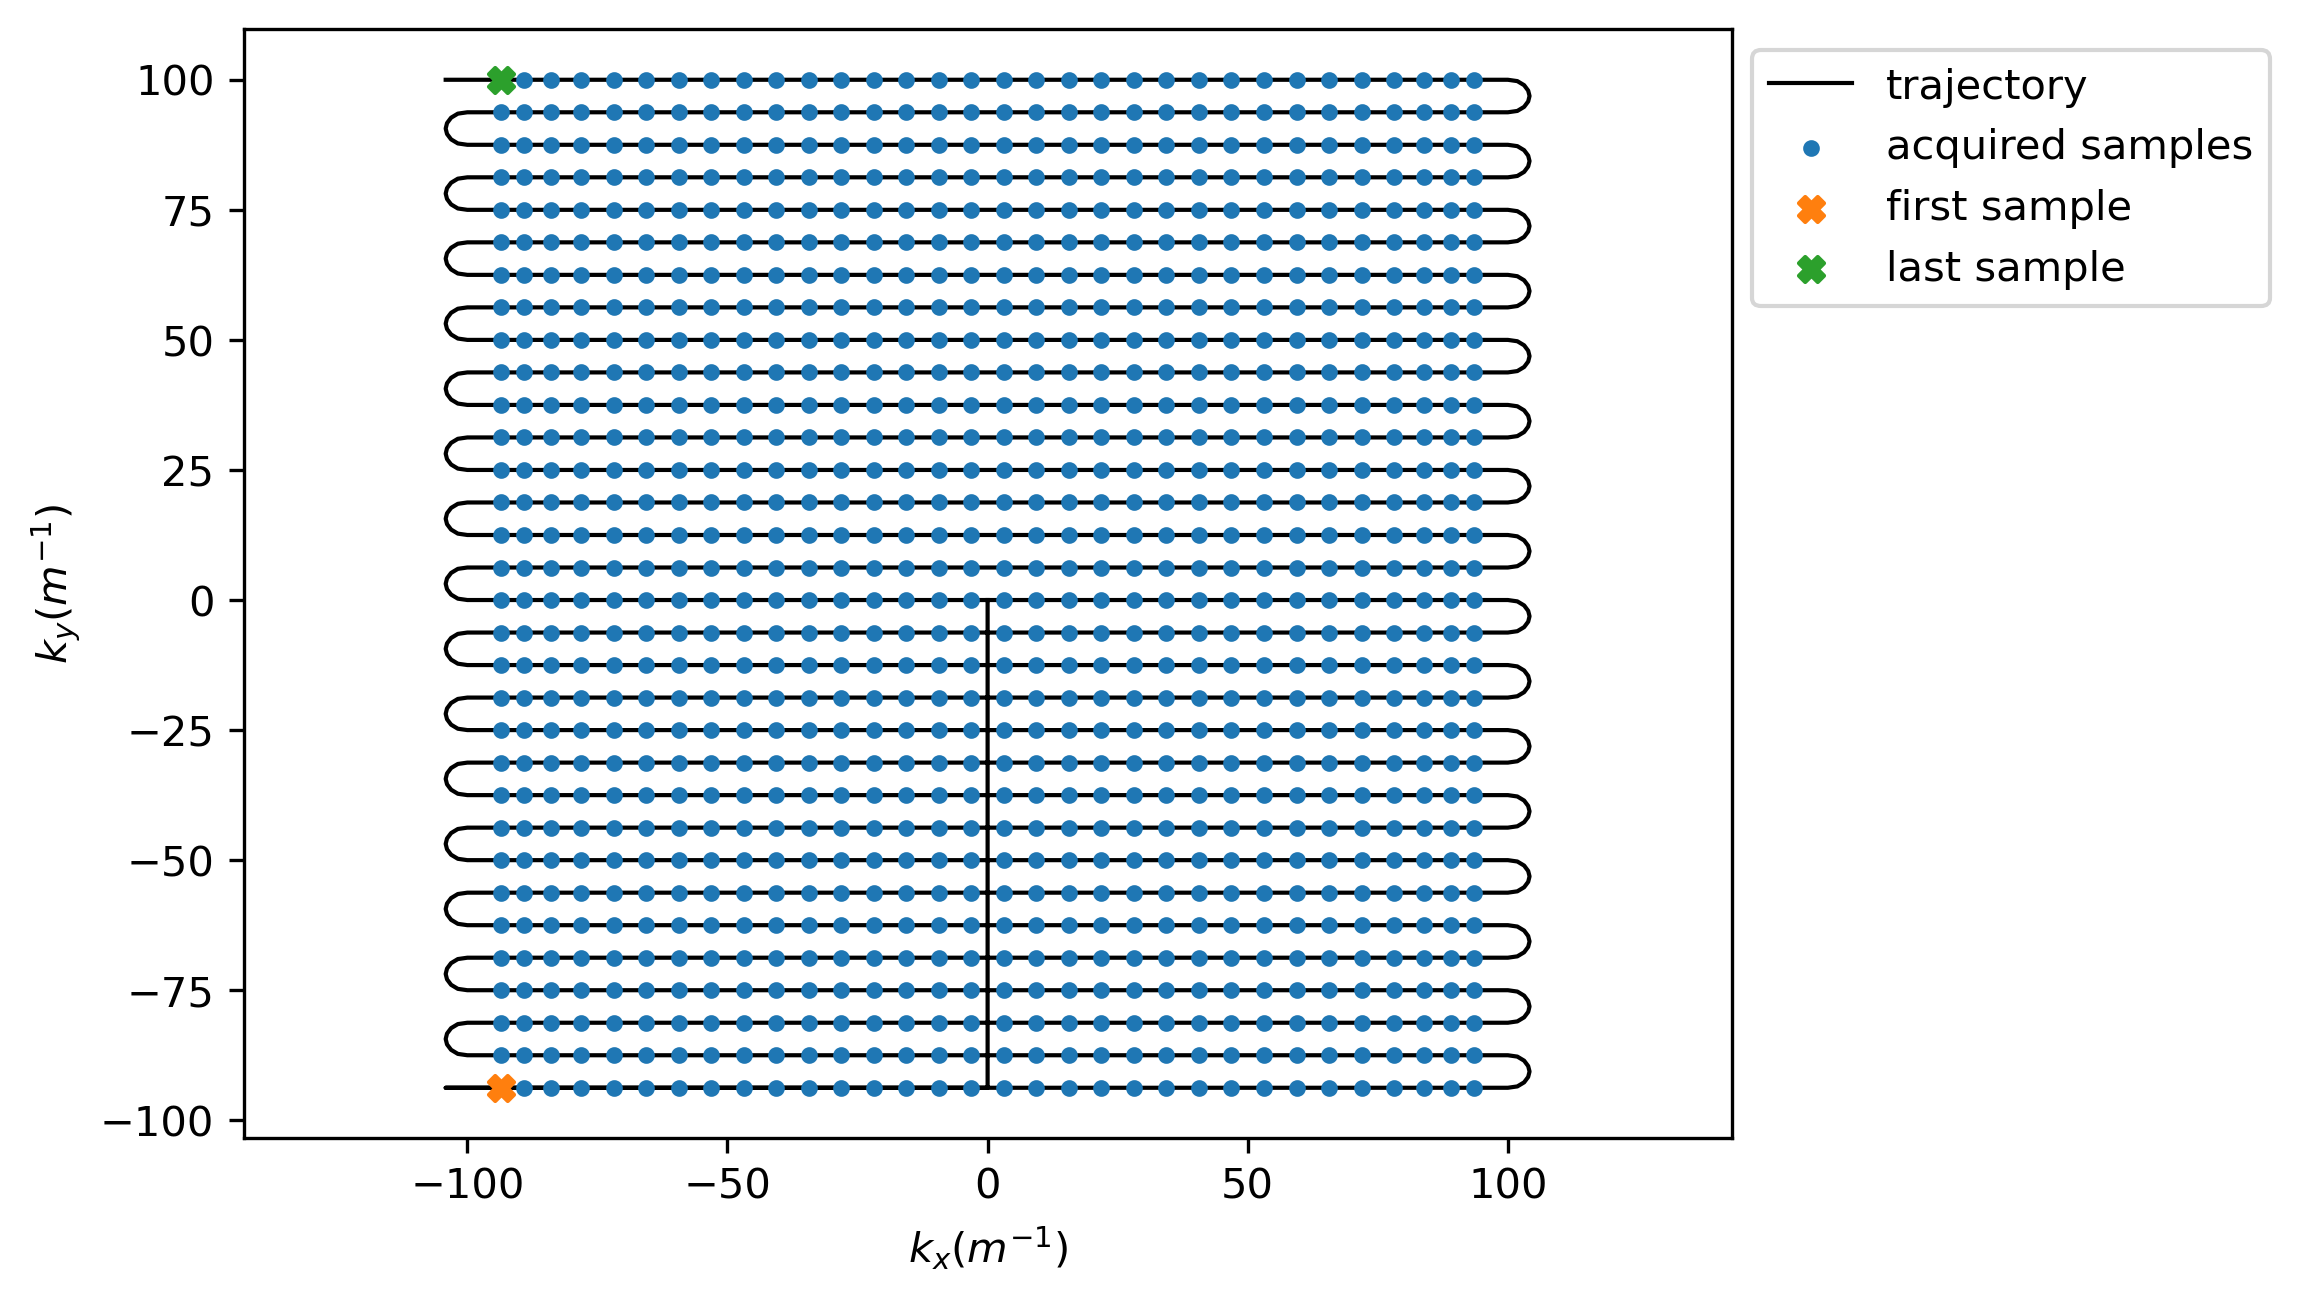

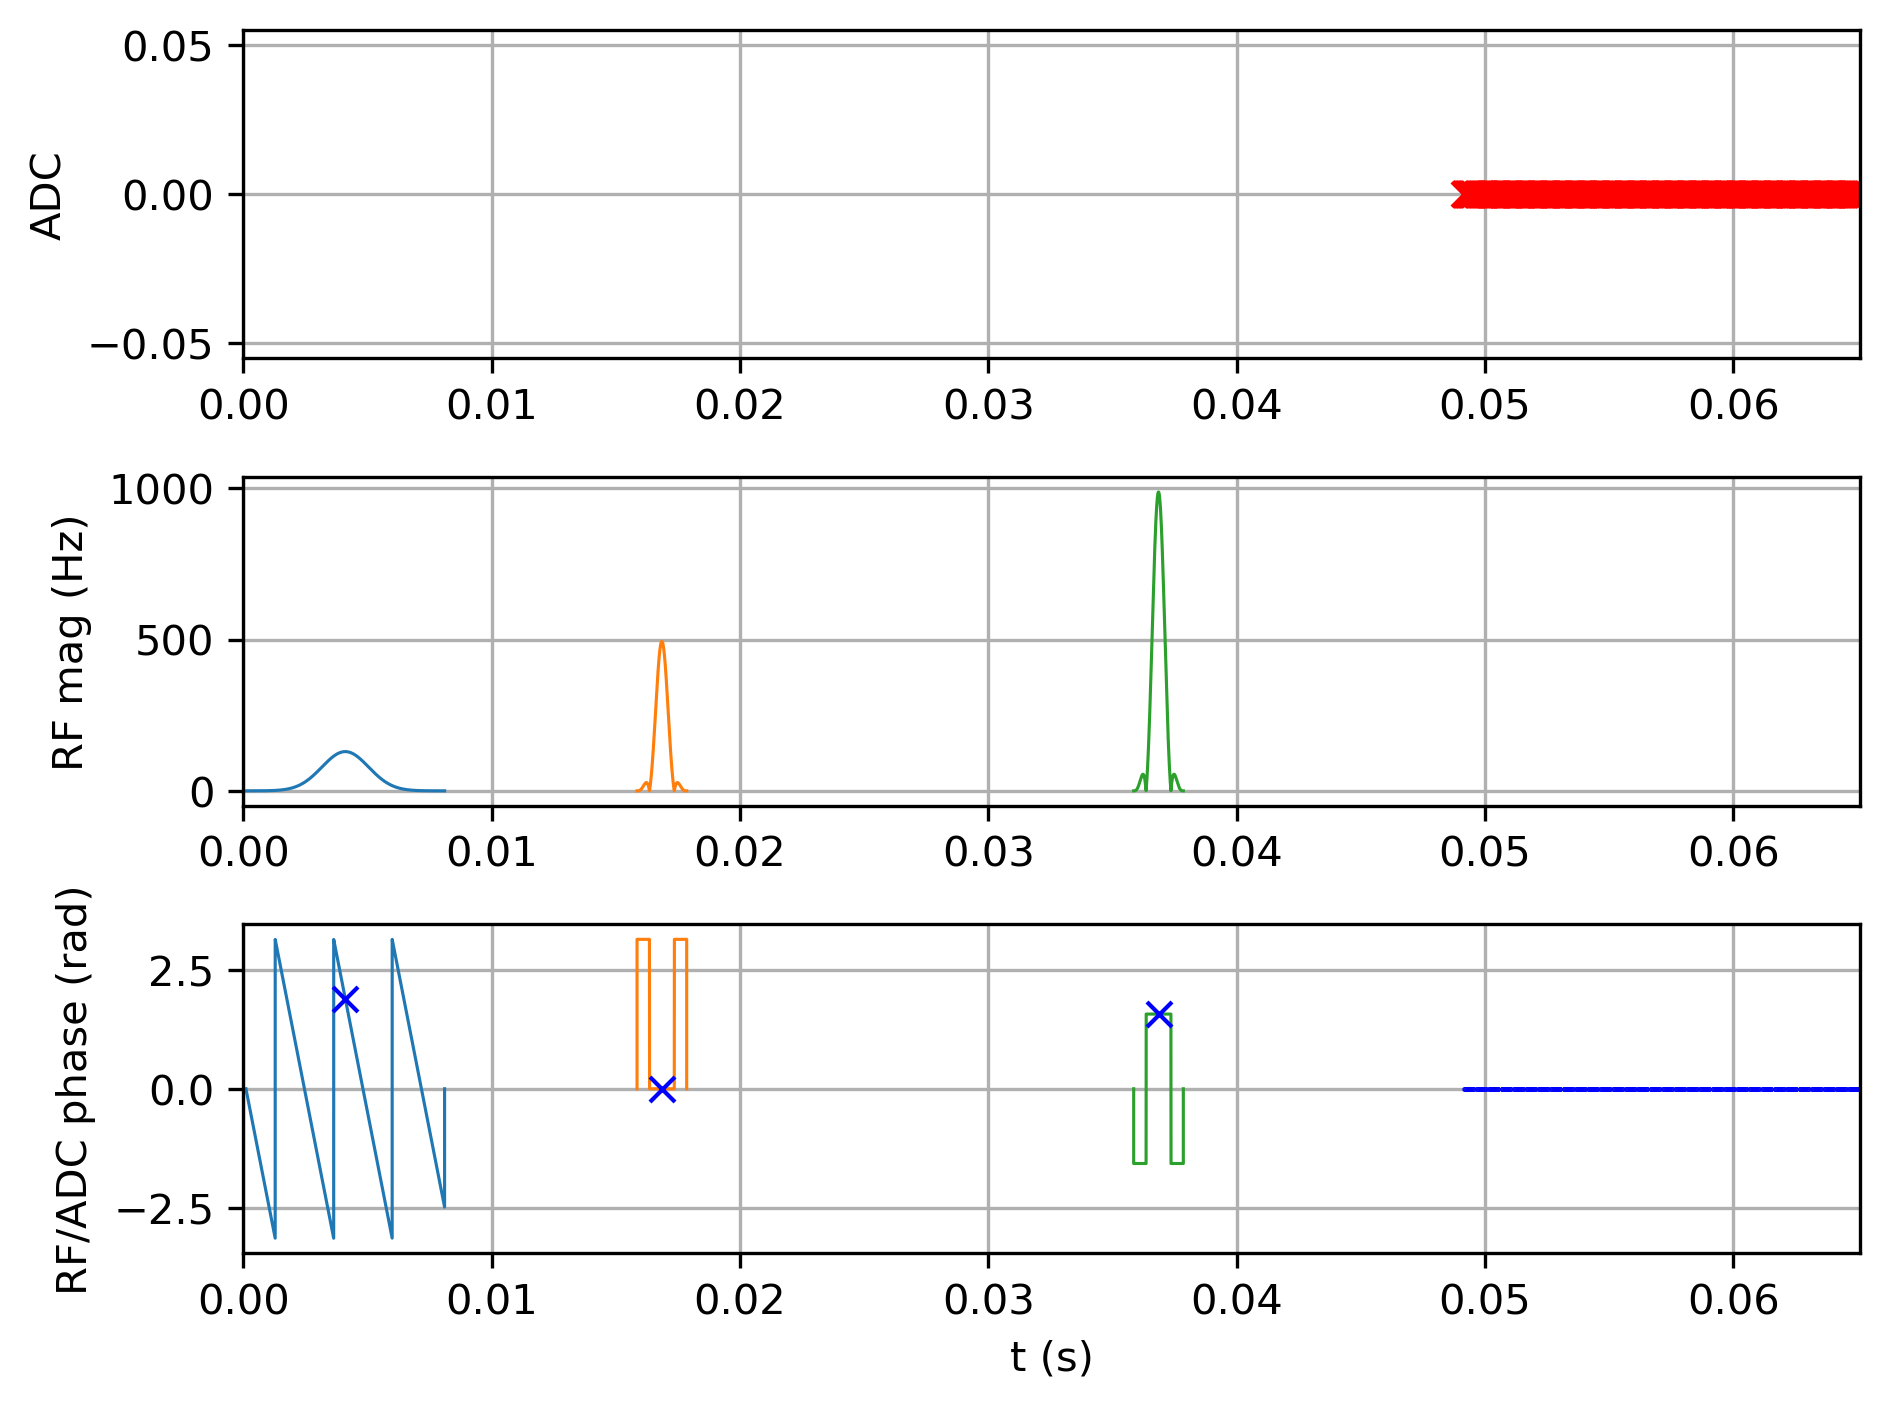

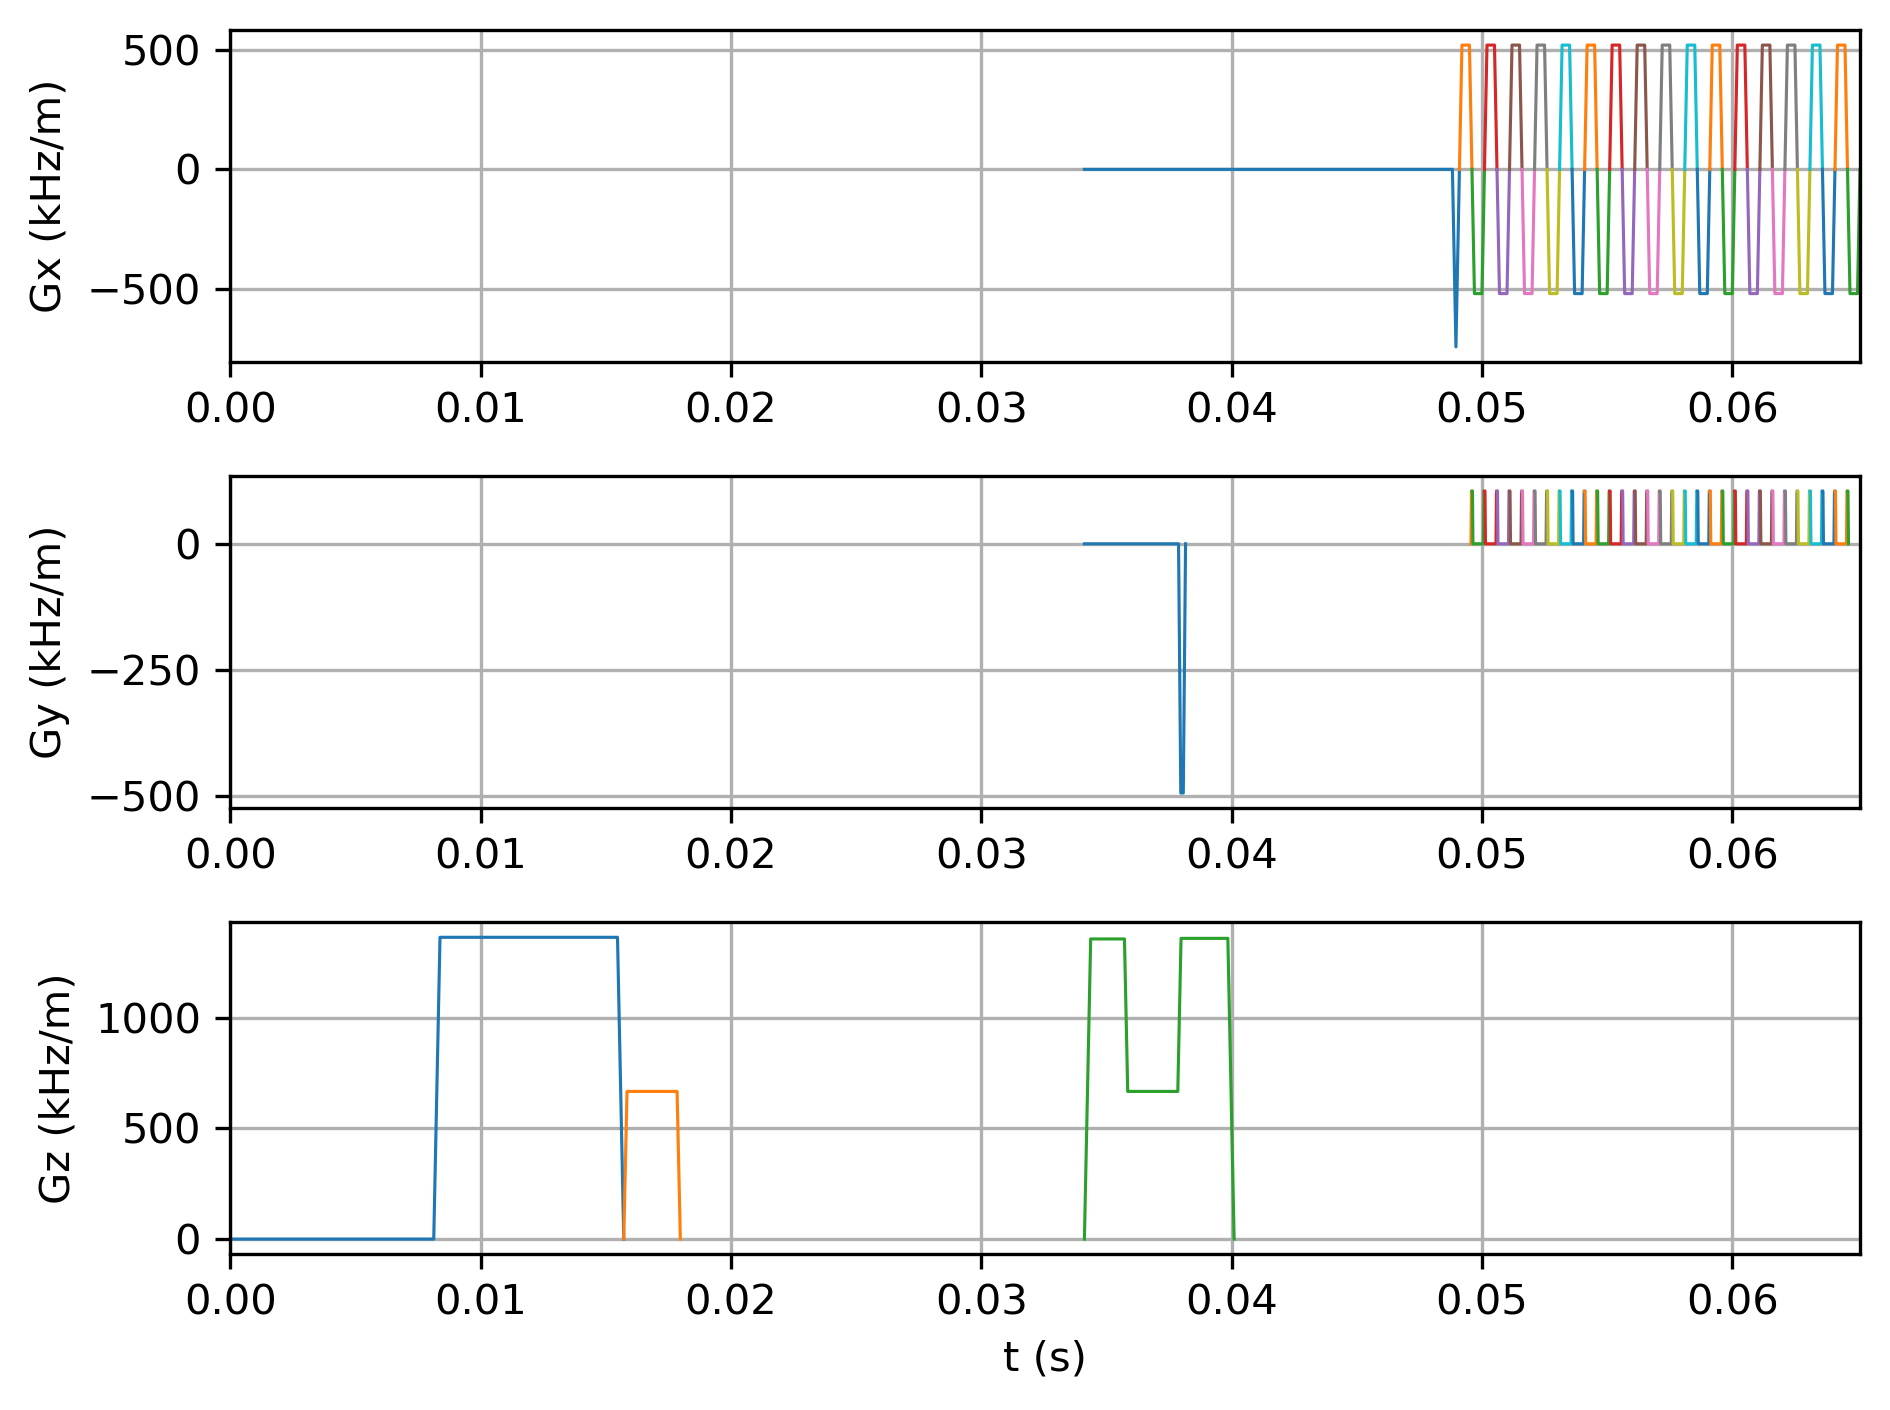

Number of blocks: 36
Number of events:
RF:      3
Gx:     33
Gy:     33
Gz:      3
ADC:     32
Delay:      0
Sequence duration: 0.065100 s
TE: 0.040012 s
TR: 0.012750 s
Flip angle: 90.00 110.00 180.00 deg
Unique k-space positions (aka cols, rows, etc.): 32 32 
Dimensions: 2
Spatial resolution: 5.35 mm
Spatial resolution: 5.00 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 744048 493421 1362398 Hz/m == 17.48 11.59 32.00 mT/m
Max slew rate: 5314625850 5482456140 5449591281 Hz/m/s == 124.83 128.77 128.00 T/m/s
Max absolute gradient: 1444492 Hz/m == 33.93 mT/m
Max absolute slew rate: 7.63581e+09 Hz/m/s == 179.35 T/m/s


In [ ]:
# VISUALIZATION
# ======

# Calculate and visualize k-space
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()
viz.plot2Dkspace(k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc)

plot = True
if plot:
    seq.plot()

# Very optional slow step, but useful for testing during development e.g. for the real TE, TR or for staying within slew-rate limits
rep = seq.test_report()
print(rep)

In [ ]:
# WRITE .SEQ
# =========
write_seq = True
seq_filename = 'rex_3_epi_se_rs.seq'
if write_seq:
    # Prepare the sequence output for the scanner
    seq.set_definition(key="FOV", value=[fov, fov, slice_thickness])
    seq.set_definition(key="Name", value="epi_se_rs")

    seq.write(seq_filename)